In [1]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')
sys.path.append('../models')

import glob

import matplotlib.pyplot as plt

from bbox_utils import generate_default_boxes, convert_to_box_form

from dataGenerator import DataGenerator
from classification_loss import SSDLoss

import numpy as np

import tensorflow as tf

import cv2

from SSD_VGG16 import buildSSD_VGG16

In [2]:
VGG_16 = buildSSD_VGG16(n_classes = 21, model_checkpoint='/home/usman/workspace/SSDModel/checkpoints/model_output')

2022-09-30 10:20:02.506372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 10:20:02.515914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 10:20:02.516915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 10:20:02.518204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                  (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                  (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                  (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                  (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

colors = [(x[0] / 255., x[1] / 255., x[2] / 255.) for x in colors_tableau]

VOC_labels = '''person,bird,cat,cow,dog,horse,sheep,aeroplane,bicycle,boat,bus,car,motorbike,train,bottle,chair,diningtable,pottedplant,sofa,tvmonitor'''

VOC_labels = VOC_labels.split(',')

In [4]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

def modelPreds(image_path, model):
    
    images = []

    image = cv2.imread(image_path)
    # image = cv2.imread('/home/usman/Downloads/woman-with-cat-asleep-medium.jpg')
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))
    
    images.append(image)
    
    images = np.array(images) / 255.
    
    pred = VGG_16.predict(images)
    
    conf_loss = pred[1]
    
    g_cx_pred = pred[0][:,:,0] * prior_boxes[:,2] / 10 + prior_boxes[:,0]
    g_cy_pred =  pred[0][:,:,1] * prior_boxes[:,3] / 10 + prior_boxes[:,1]
    g_w_pred = tf.exp(pred[0][:,:,2] / 5) * prior_boxes[:,2]
    g_h_pred = tf.exp(pred[0][:,:,3] / 5) * prior_boxes[:,3]

    g_x_min = g_cx_pred - g_w_pred / 2
    g_y_min = g_cy_pred - g_h_pred / 2

    g_x_max = g_cx_pred + g_w_pred / 2
    g_y_max = g_cy_pred + g_h_pred / 2

    # tf.transpose(g_x_min, perm=(0,1))

    g_x_min_t = tf.transpose(tf.expand_dims(g_x_min, axis = 0), perm=(1,2,0))
    g_y_min_t = tf.transpose(tf.expand_dims(g_y_min, axis = 0), perm=(1,2,0))

    g_x_max_t = tf.transpose(tf.expand_dims(g_x_max, axis = 0), perm=(1,2,0))
    g_y_max_t = tf.transpose(tf.expand_dims(g_y_max, axis = 0), perm=(1,2,0))

    g_pred = tf.concat([g_x_min_t, g_y_min_t, g_x_max_t, g_y_max_t], axis = 2)
    
    image_number = 0
    
    selected_indices = tf.image.non_max_suppression(
                    g_pred[image_number], 
                    tf.reduce_max(conf_loss[image_number][:,1:], axis = 1), 
                    max_output_size=50,
                    iou_threshold=0.7,
                    score_threshold=0.5)

    selected_boxes = tf.gather(g_pred[image_number], selected_indices)
    labels_for_boxes = tf.argmax(tf.gather(conf_loss[image_number], selected_indices),axis = 1)
    confidence_score = tf.reduce_max(tf.gather(conf_loss[image_number], selected_indices), axis = 1)
    
    return selected_boxes, labels_for_boxes, confidence_score

In [47]:
image_path = '/home/usman/Downloads/urban-mushing-1150x700.jpg'
selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, VGG_16)

(700, 1150, 3)
1/1 [==============================] - 0s 26ms/step


In [48]:
def plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, labels, colors):
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    figsize=(10,10)
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    height = image.shape[0]
    width = image.shape[1]
    linewidth=1.5
    for i in range(confidence_score.shape[0]):

        score = confidence_score[i]
        xmin = int(selected_boxes[i, 0] * width)
        ymin = int(selected_boxes[i, 1] * height)
        xmax = int(selected_boxes[i, 2] * width)
        ymax = int(selected_boxes[i, 3] * height)
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False,
                             edgecolor=colors[i],
                             linewidth=linewidth)
        plt.gca().add_patch(rect)
        label_idx = labels_for_boxes[i].numpy()
        class_name = str(labels[label_idx - 1])
        plt.gca().text(xmin, ymin - 2,
                       '{:s} | {:.3f}'.format(class_name, score),
                       bbox=dict(facecolor=colors[i], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

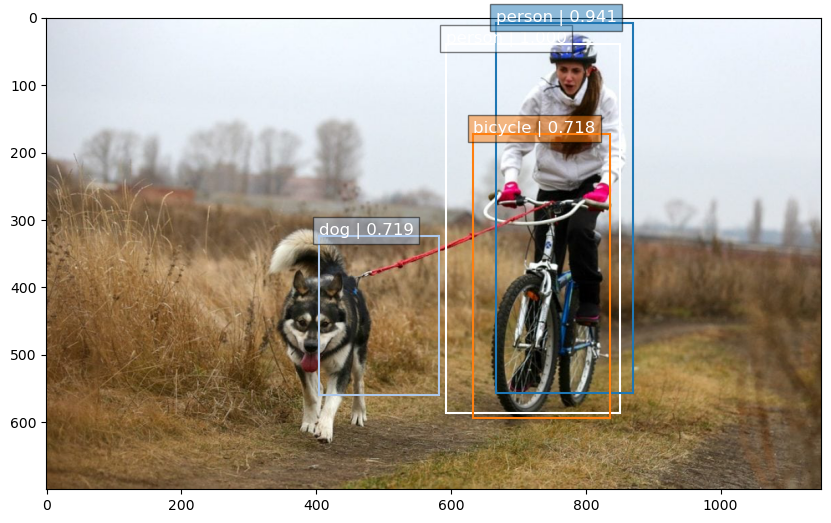

In [49]:
plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, VOC_labels, colors)